## Making predictions of the closing price of bitcoin using random forrest regression model ##

bitcoin_tweets_Price_data is the cleaned/preprocessed file that contains 10016 records down from the intial 95762468 records of twitter and bitcoin data. The dataset will be used for making the prediction of close price of bitcoin y, based on a set of features that are defined below.

If you'd only like to run the predictions and not go thorugh the preprocessing, please make sure you have all the libraries needed, if not. you can run pip install -r requirements.txt(file in repo) in your command line to install all the needed libraries

In [ ]:
#get_ipython().system('pip install -r requirements.txt')

#Data Source
import numpy as np
import pandas as pd
import pylab as p
import matplotlib.pyplot as plot
import re
import yfinance as yf
#Data visualization
import plotly.graph_objs as go


#importing packages for the prediction of time-series data
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error

#Importing the packages for the prediction of time-seri
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV


from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


scaler = MinMaxScaler()


In [2]:
bitcoin_tweets_Price_data = pd.read_csv('Bitcoin_tweets_Price_data.csv')

In [3]:
bitcoin_tweets_Price_data.columns

Index(['Unnamed: 0', 'date', 'text', 'user_followers', 'user_favourites',
       'Compound', 'Open', 'High', 'Low', 'Close', 'Volume'],
      dtype='object')

In [34]:
bitcoin_tweets_Price_data.shape

(10016, 11)

In [4]:
#plotting to check the correlation between user_followers and the closing price
fig = go.Figure(data=go.Scatter(x=bitcoin_tweets_Price_data['user_followers'], y=bitcoin_tweets_Price_data['Close'], mode='markers'))
fig.show()

In [5]:
#Plotting to check the correlation between user_favourites and the closing price
fig = go.Figure(data=go.Scatter(x=bitcoin_tweets_Price_data['user_favourites'], y=bitcoin_tweets_Price_data['Close'], mode='markers'))
fig.show()

The data we have, has already been filtered on the median of user favorites and followers columns, using them as feature should be benign and have no effect, but we will only discard them if they are having a negative effect on our accuracy.

In [6]:
bitcoin_tweets_Price_data.columns


Index(['Unnamed: 0', 'date', 'text', 'user_followers', 'user_favourites',
       'Compound', 'Open', 'High', 'Low', 'Close', 'Volume'],
      dtype='object')

Since bitcoin data is time series, hence non stationary, a good idea would be to normalize the data, here we are using min-max scaling to scale down 'Open','High','Low','Close', 'Volume' values from 0-1. We can later scale them back to their dollar amount

In [7]:
#MinMaxScaler is used to normalize the data
scaler = MinMaxScaler()
training_data = scaler.fit_transform(bitcoin_tweets_Price_data[['Open','High','Low','Close', 'Volume']])
bitcoin_tweets_Price_data

,Unnamed: 0,date,text,user_followers,user_favourites,Compound,Open,High,Low,Close,Volume
0,0,2021-02-10,blockstreamaqua is our new bitcoin and walle...,131970.0,12454.0,0.4404,46469.761719,47145.566406,43881.152344,44918.183594,87301089896
1,1,2021-02-09,hedgeye crypto quant tc 2 7 eth 2 8 ...,195162.0,15986.0,0.5106,46184.992188,48003.722656,45166.960938,46481.105469,91809846886
2,2,2021-02-09,drop some sats pick up some bitcoin stickers ...,131972.0,12456.0,-0.3612,46184.992188,48003.722656,45166.960938,46481.105469,91809846886
3,3,2021-02-09,bitcoin surges past 48 000 pulling other cry...,758587.0,9277.0,0.0000,46184.992188,48003.722656,45166.960938,46481.105469,91809846886
4,4,2021-02-09,stock futures are lower following the s amp p ...,758587.0,9277.0,0.2732,46184.992188,48003.722656,45166.960938,46481.105469,91809846886
...,...,...,...,...,...,...,...,...,...,...,...
10011,10011,2023-01-07,crypto news today huobi to layoff 20 of...,1320968.0,57367.0,0.5778,16952.117188,16975.017578,16914.191406,16955.078125,7714767174
10012,10012,2023-01-06,market conditions today dji 2 12 33 630...,362223.0,23862.0,0.0000,16836.472656,16991.994141,16716.421875,16951.968750,14413662913
10013,10013,2023-01-06,i smell bulls btc,100887.0,58534.0,0.0000,16836.472656,16991.994141,16716.421875,16951.968750,14413662913
10014,10014,2023-01-06,shill me your best gem x100 btc eth doge...,247412.0,21964.0,0.6369,16836.472656,16991.994141,16716.421875,16951.968750,14413662913


In [8]:
#Creating a new dataframe with the scaled values and copying the original dataframe
bitcoin_tweets_Price_minmax_scaled = bitcoin_tweets_Price_data.copy()

In [9]:
bitcoin_tweets_Price_minmax_scaled.head()
bitcoin_tweets_Price_minmax_scaled.drop(['Unnamed: 0'], axis=1, inplace=True)

In [10]:
bitcoin_tweets_Price_minmax_scaled.head()

,date,text,user_followers,user_favourites,Compound,Open,High,Low,Close,Volume
0,2021-02-10,blockstreamaqua is our new bitcoin and walle...,131970.0,12454.0,0.4404,46469.761719,47145.566406,43881.152344,44918.183594,87301089896
1,2021-02-09,hedgeye crypto quant tc 2 7 eth 2 8 ...,195162.0,15986.0,0.5106,46184.992188,48003.722656,45166.960938,46481.105469,91809846886
2,2021-02-09,drop some sats pick up some bitcoin stickers ...,131972.0,12456.0,-0.3612,46184.992188,48003.722656,45166.960938,46481.105469,91809846886
3,2021-02-09,bitcoin surges past 48 000 pulling other cry...,758587.0,9277.0,0.0000,46184.992188,48003.722656,45166.960938,46481.105469,91809846886
4,2021-02-09,stock futures are lower following the s amp p ...,758587.0,9277.0,0.2732,46184.992188,48003.722656,45166.960938,46481.105469,91809846886


In [11]:
#replace the columns with the scaled values
bitcoin_tweets_Price_minmax_scaled[['Open','High','Low','Close','Volume']] = training_data

In [12]:
bitcoin_tweets_Price_minmax_scaled.head()

,date,text,user_followers,user_favourites,Compound,Open,High,Low,Close,Volume
0,2021-02-10,blockstreamaqua is our new bitcoin and walle...,131970.0,12454.0,0.4404,0.610279,0.609298,0.582159,0.580233,0.715205
1,2021-02-09,hedgeye crypto quant tc 2 7 eth 2 8 ...,195162.0,15986.0,0.5106,0.604597,0.626244,0.608626,0.611363,0.755723
2,2021-02-09,drop some sats pick up some bitcoin stickers ...,131972.0,12456.0,-0.3612,0.604597,0.626244,0.608626,0.611363,0.755723
3,2021-02-09,bitcoin surges past 48 000 pulling other cry...,758587.0,9277.0,0.0000,0.604597,0.626244,0.608626,0.611363,0.755723
4,2021-02-09,stock futures are lower following the s amp p ...,758587.0,9277.0,0.2732,0.604597,0.626244,0.608626,0.611363,0.755723


In [13]:
bitcoin_tweets_Price_minmax_scaled = pd.read_csv("bitcoin_tweets_Price_minmax_scaled.csv")
bitcoin_tweets_Price_minmax_scaled.drop(['Unnamed: 0'], axis=1, inplace=True)

In [14]:
bitcoin_tweets_Price_minmax_scaled

,date,text,user_followers,user_favourites,Compound,Open,High,Low,Close,Volume
0,2021-02-10,blockstreamaqua is our new bitcoin and walle...,131970.0,12454.0,0.4404,0.610279,0.609298,0.582159,0.580233,0.715205
1,2021-02-09,hedgeye crypto quant tc 2 7 eth 2 8 ...,195162.0,15986.0,0.5106,0.604597,0.626244,0.608626,0.611363,0.755723
2,2021-02-09,drop some sats pick up some bitcoin stickers ...,131972.0,12456.0,-0.3612,0.604597,0.626244,0.608626,0.611363,0.755723
3,2021-02-09,bitcoin surges past 48 000 pulling other cry...,758587.0,9277.0,0.0000,0.604597,0.626244,0.608626,0.611363,0.755723
4,2021-02-09,stock futures are lower following the s amp p ...,758587.0,9277.0,0.2732,0.604597,0.626244,0.608626,0.611363,0.755723
...,...,...,...,...,...,...,...,...,...,...
10011,2023-01-07,crypto news today huobi to layoff 20 of...,1320968.0,57367.0,0.5778,0.021328,0.013503,0.027071,0.023260,0.000000
10012,2023-01-06,market conditions today dji 2 12 33 630...,362223.0,23862.0,0.0000,0.019021,0.013839,0.023000,0.023198,0.060200
10013,2023-01-06,i smell bulls btc,100887.0,58534.0,0.0000,0.019021,0.013839,0.023000,0.023198,0.060200
10014,2023-01-06,shill me your best gem x100 btc eth doge...,247412.0,21964.0,0.6369,0.019021,0.013839,0.023000,0.023198,0.060200


We now have the scaled data, we can start building out our Ml model to make predictions

In [15]:
#Assigning the features and the target variable
features = ['user_followers','user_favourites','Compound','Open','High','Low','Close','Volume']

In [16]:
#Assigning the target variable
y = bitcoin_tweets_Price_minmax_scaled['Close']
x = bitcoin_tweets_Price_minmax_scaled[features]

In [17]:
#Splitting the data into training and testing data
train_X, test_X, train_y, test_y = train_test_split(x, y, random_state=1)

Using the default train test split, 7,512 datapoints for training and 2,504 for testing

In [18]:
#Using the random forest regressor
randomforest_model = RandomForestRegressor(random_state=1,n_estimators=10)

In [19]:
#Fitting the model
randomforest_model.fit(train_X, train_y)

RandomForestRegressor(n_estimators=10, random_state=1)

In [20]:
#Predicting the values
randomforest_predict = randomforest_model.predict(test_X)

In [21]:
randomforest_predict

array([0.5050566 , 0.56093034, 0.08981921, ..., 0.51220363, 0.06712726,
       0.08813348])

In [22]:
print(randomforest_model.predict(x))
bitcoin_tweets_Price_minmax_scaled['Close']

[0.57995957 0.61136309 0.61136309 ... 0.02319832 0.02319832 0.02319832]


0        0.580233
1        0.611363
2        0.611363
3        0.611363
4        0.611363
           ...   
10011    0.023260
10012    0.023198
10013    0.023198
10014    0.023198
10015    0.023198
Name: Close, Length: 10016, dtype: float64

In [37]:
#Finding mean absolute error for normalized data
from sklearn.metrics import mean_absolute_error
randomforest_test_mae = mean_absolute_error(test_y,randomforest_predict)
randomforest_test_mae

converted_value = format(randomforest_test_mae, 'f')
print(converted_value)

0.000020


Our Mean Absolute error is 0.000020, a very good measure of our models accuracy

In [24]:
scaler.scale_

array([1.99524827e-05, 1.97475602e-05, 2.05839920e-05, 1.99181159e-05,
       8.98652663e-12])

In [25]:
#Scaling back the values to find the mean absolute error for the original data
scale = 1/1.99524827e-05
Y_pred = randomforest_predict*scale
Y_test = test_y*scale
Y_pred
mean_absolute_error(Y_test,Y_pred)


1.0138434195544401

In term of dollar amount, after scaling the value back, our mean absolute error is 1.0138434195544401 or 1 USD appox

In [26]:
bitcoin_tweets_Price_minmax_scaled

,date,text,user_followers,user_favourites,Compound,Open,High,Low,Close,Volume
0,2021-02-10,blockstreamaqua is our new bitcoin and walle...,131970.0,12454.0,0.4404,0.610279,0.609298,0.582159,0.580233,0.715205
1,2021-02-09,hedgeye crypto quant tc 2 7 eth 2 8 ...,195162.0,15986.0,0.5106,0.604597,0.626244,0.608626,0.611363,0.755723
2,2021-02-09,drop some sats pick up some bitcoin stickers ...,131972.0,12456.0,-0.3612,0.604597,0.626244,0.608626,0.611363,0.755723
3,2021-02-09,bitcoin surges past 48 000 pulling other cry...,758587.0,9277.0,0.0000,0.604597,0.626244,0.608626,0.611363,0.755723
4,2021-02-09,stock futures are lower following the s amp p ...,758587.0,9277.0,0.2732,0.604597,0.626244,0.608626,0.611363,0.755723
...,...,...,...,...,...,...,...,...,...,...
10011,2023-01-07,crypto news today huobi to layoff 20 of...,1320968.0,57367.0,0.5778,0.021328,0.013503,0.027071,0.023260,0.000000
10012,2023-01-06,market conditions today dji 2 12 33 630...,362223.0,23862.0,0.0000,0.019021,0.013839,0.023000,0.023198,0.060200
10013,2023-01-06,i smell bulls btc,100887.0,58534.0,0.0000,0.019021,0.013839,0.023000,0.023198,0.060200
10014,2023-01-06,shill me your best gem x100 btc eth doge...,247412.0,21964.0,0.6369,0.019021,0.013839,0.023000,0.023198,0.060200


## Below Plots ##

1. Predictions Vs True Bitcoin Prices for the normalized values
2. Predictions Vs True Bitcoin Prices for the Actual values

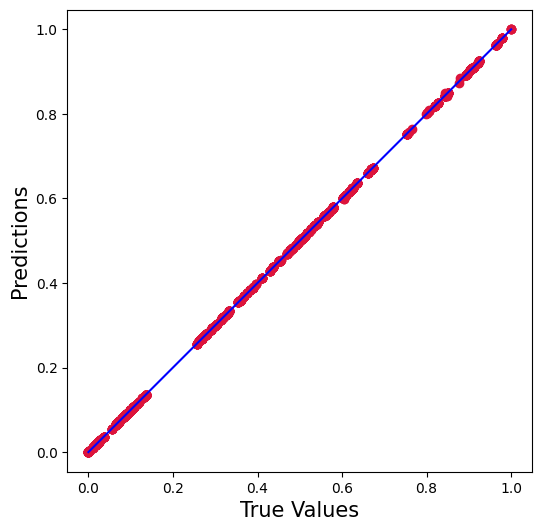

In [27]:
import matplotlib.pyplot as plt
#Plotting the actual and predicted values for normalized values
plt.figure(figsize=(6,6))
plt.scatter(test_y,randomforest_predict, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(test_y), max(randomforest_predict))
p2 = min(min(test_y), min(randomforest_predict))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

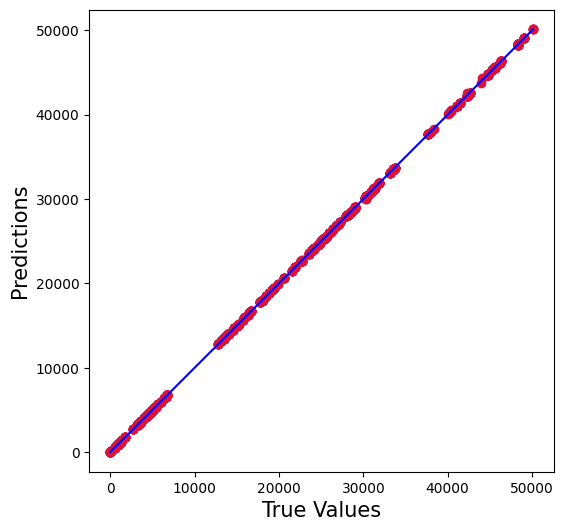

In [28]:
#Plotting the actual and predicted values for original values
plt.figure(figsize=(6,6))
plt.scatter(Y_test, Y_pred, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(Y_test), max(Y_pred))
p2 = min(min(Y_test), min(Y_pred))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Since Random forrest is an ensemble method, where multiple decision trees are utilized, how would the results look like for a single decision tree, below are the results

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn import tree
#import graphviz


In [30]:
#Using the decision tree regressor to plot a tree
dtc = DecisionTreeRegressor(random_state=1,max_depth=3)
dtc.fit(train_X, train_y)

DecisionTreeRegressor(max_depth=3, random_state=1)

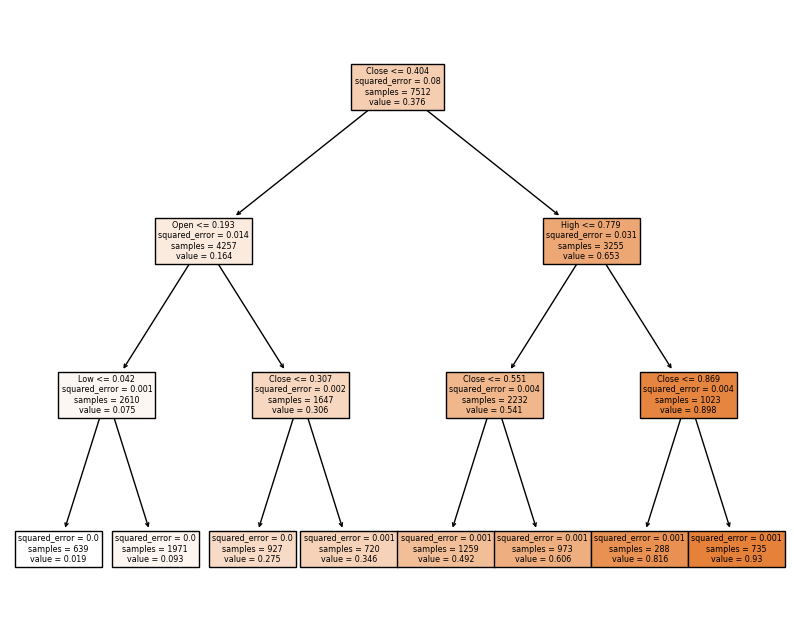

In [31]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(10, 8))
tree.plot_tree(dtc, feature_names=train_X.columns, filled=True)
plt.show()

In [32]:
#Downloading a tree in dot format
export_graphviz(dtc, out_file='tree.dot',
                feature_names=features,
                filled=True,
                rounded=True)


In [33]:
# convert the decision tree to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0